In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import lumicks.pylake as lk

%matplotlib inline

# Notebook Widgets

[Download this page as a Jupyter notebook](https://lumicks-pylake.readthedocs.io/en/stable/_downloads/8b3909c096d00c9cddcf8890e275db10/nbwidgets.ipynb)

When analyzing notebooks, it can be helpful to make use of interactive widgets. For this, we provide some widgets to help you analyze your data. To enable such widgets, start the notebook with:

In [ ]:
# enable this line if you are using jupyter lab
%matplotlib widget

# enable this line if you are using jupyter notebook
# %matplotlib notebook

We can download the data needed for this tutorial directly from Zenodo using Pylake. Since we don’t want it in our working folder, we’ll put it in a folder called `"test_data"`:

In [ ]:
kymo_filenames = lk.download_from_doi("10.5281/zenodo.7729525", "test_data")
stack_filenames = lk.download_from_doi("10.5281/zenodo.7729700", "test_data")
fd_filenames = lk.download_from_doi("10.5281/zenodo.7729929", "test_data")

## Channel slicing

Let’s say we want to do some analyses on slices of channel data. It would be nice to just quickly visually select some regions using a widget. Let’s load the file and open an interactive plot using the [`range_selector()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.channel.Slice.html#lumicks.pylake.channel.Slice.range_selector) method:

In [ ]:
file = lk.File("test_data/kymo.h5")
channel = file["Force HF"]["Force 1x"]

plt.figure()
selector = channel.range_selector()

This returns a [`SliceRangeSelectorWidget`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.nb_widgets.range_selector.SliceRangeSelectorWidget.html#lumicks.pylake.nb_widgets.range_selector.SliceRangeSelectorWidget). You can use the left mouse button to select time ranges (by clicking the left and then the right boundary of the region you wish to select). The right mouse button can be used to remove previous selections. We can access the selected timestamps of the ranges we selected by accessing the [`ranges`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.nb_widgets.range_selector.SliceRangeSelectorWidget.html#lumicks.pylake.nb_widgets.range_selector.SliceRangeSelectorWidget.ranges) property:

In [ ]:
selector.ranges

And the actual slices from [`slices`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.nb_widgets.range_selector.SliceRangeSelectorWidget.html#lumicks.pylake.nb_widgets.range_selector.SliceRangeSelectorWidget.slices). If we want to plot all of our selections in separate plots for instance, we can do the following:

In [ ]:
plt.figure(figsize=(3, 6))
for idx, data_slice in enumerate(selector.slices):
    plt.subplot(len(selector.slices), 1, idx + 1)
    data_slice.plot()

plt.tight_layout()

## F,d selection

### Range selection by time

Assume we have an F,d curve we want to analyze. We know that this file contains one F,d curve which should be split up into three segments that should be analyzed separately. Let’s open the [`FdRangeSelector`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.FdRangeSelector.html#lumicks.pylake.FdRangeSelector) and make a few selections:

In [ ]:
file = lk.File("test_data/fd_multiple_Lc.h5")
fdcurves = file.fdcurves
selector = lk.FdRangeSelector(fdcurves)

This opens up a little widget, where you can use the left mouse button to select time ranges and the right mouse button to remove previous selections.

After making a few selections, the properties [`ranges`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.FdRangeSelector.html#lumicks.pylake.FdRangeSelector.ranges) and [`fdcurves`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.FdRangeSelector.html#lumicks.pylake.FdRangeSelector.fdcurves) contain the time ranges and force extension curves corrseponding to our selection. Once we’ve selected some time ranges, we can output the timestamps using the [`ranges`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.FdRangeSelector.html#lumicks.pylake.FdRangeSelector.ranges) property:

In [ ]:
selector.ranges

These timestamps can directly be used to extract the relevant data:

In [ ]:
plt.figure(figsize=(8, 2.5))
for idx, (t_start, t_stop) in enumerate(selector.ranges["40"]):
    plt.subplot(1, len(selector.ranges["40"]), idx + 1)
    plt.scatter(
        fdcurves["40"].d[t_start:t_stop].data,
        fdcurves["40"].f[t_start:t_stop].data,
        s=2,  # Use a smaller marker size
    )
    plt.xlabel("Distance [$\mu$m]")
    plt.ylabel("Force [pN]")

plt.tight_layout()

This produces a separate plot for each selection. There’s also a more direct way to get these plots, namely through [`fdcurves`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.FdRangeSelector.html#lumicks.pylake.FdRangeSelector.fdcurves). This gives you an [`FdCurve`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.fdcurve.FdCurve.html#lumicks.pylake.fdcurve.FdCurve) for each section you selected:

In [ ]:
plt.figure()
for fdcurve in selector.fdcurves["40"]:
    fdcurve.plot_scatter()

### Processing multiple files

Now let’s say our experiment is split up over multiple files, each containing a few F,d curves. We would like to load these curves all at once and make our selections. We can do this using automatically using `glob`. With `glob.glob` we grab a list of all `.h5` files in the directory `my_directory`. We then iterate over this list and open each file. Then, for all those files, we add each individual curves to our variable `fdcurves`:

In [ ]:
import glob

fdcurves = {}
for filename in glob.glob('test_data/*.h5'):
    file = lk.File(filename)
    for key, curve in file.fdcurves.items():
        fdcurves[key] = curve

Using this dictionary, we can open our widget and see all the data at once:

In [ ]:
selector = lk.FdRangeSelector(fdcurves)

Plotting the curves can be done similarly as before. Here `.values()` indicates that we want the values from the dictionary of curve sets, and not the keys (which in our case are the curve names):

In [ ]:
for curve_set in selector.fdcurves.values():
    if curve_set:
        # Open a figure only if we selected regions in this dataset
        plt.figure()
    for fdcurve in curve_set:
        fdcurve.plot_scatter()

### Range selection by distance

It is also possible to select a portion of an F,d curve based on distance using the [`FdDistanceRangeSelector`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.FdDistanceRangeSelector.html#lumicks.pylake.FdDistanceRangeSelector):

In [ ]:
selector = lk.FdDistanceRangeSelector(fdcurves)

Again, we can retrieve the selected data from [`ranges`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.FdDistanceRangeSelector.html#lumicks.pylake.FdDistanceRangeSelector.ranges) and [`fdcurves`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.FdDistanceRangeSelector.html#lumicks.pylake.FdDistanceRangeSelector.fdcurves) just as with [`FdRangeSelector`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.FdRangeSelector.html#lumicks.pylake.FdRangeSelector):

In [ ]:
original = fdcurves["40"]
sliced = selector.fdcurves["40"][0]

plt.figure()

plt.subplot(2, 1, 1)
original.plot_scatter(label="original")
sliced.plot_scatter(label="sliced")
plt.legend()

plt.subplot(2, 1, 2)
original.f.plot()
sliced.f.plot(start=original.start)

plt.tight_layout()

The returned F,d curves correspond to the longest contiguous (in time) stretch of data that falls within the distance thresholds.

### Range selection of single curve

The selector widgets can also be easily accessed from single [`FdCurve`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.fdcurve.FdCurve.html#lumicks.pylake.fdcurve.FdCurve) instances using [`range_selector()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.fdcurve.FdCurve.html#lumicks.pylake.fdcurve.FdCurve.range_selector):

In [ ]:
plt.figure()
fdcurve = fdcurves["40"]
t_selector = fdcurve.range_selector()

And for the distance-based selector we can use [`distance_range_selector()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.fdcurve.FdCurve.html#lumicks.pylake.fdcurve.FdCurve.distance_range_selector):

In [ ]:
plt.figure()
d_selector = fdcurve.distance_range_selector()
plt.show()

## Cropping and Rotating Image Stacks

You can interactively define the location of a tether for a [`ImageStack`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.ImageStack.html#lumicks.pylake.ImageStack) by using [`crop_and_rotate()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.ImageStack.html#lumicks.pylake.ImageStack.crop_and_rotate):

In [ ]:
stack = lk.ImageStack("test_data/tether.tiff")
editor = stack.crop_and_rotate()
plt.show()

Simply left-click on the start of the tether

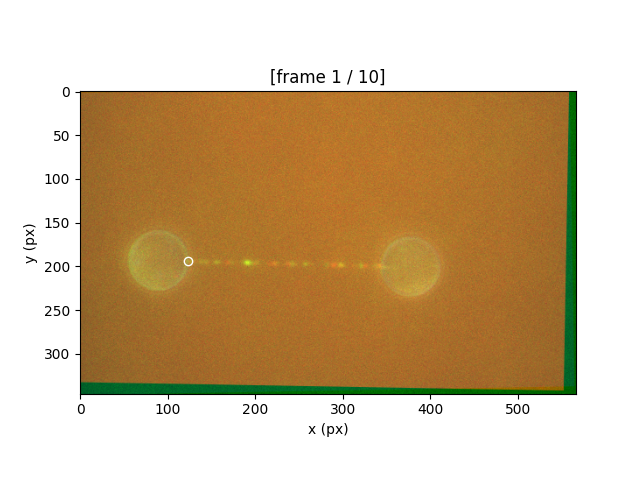

and then on the end of the tether

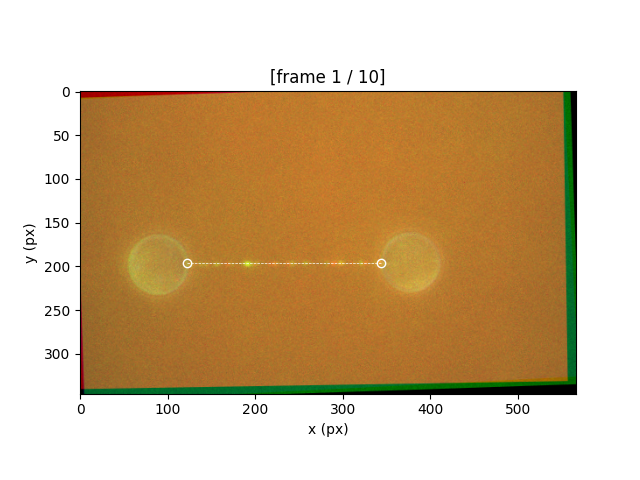

After a tether is defined, the view will update showing the location of the tether and the image rotated such that the tether is horizontal.

To crop an image, right-click and drag a rectangle around the region of interest. Once the rectangle is defined, you can edit the shape by right-clicking and dragging the various handles.

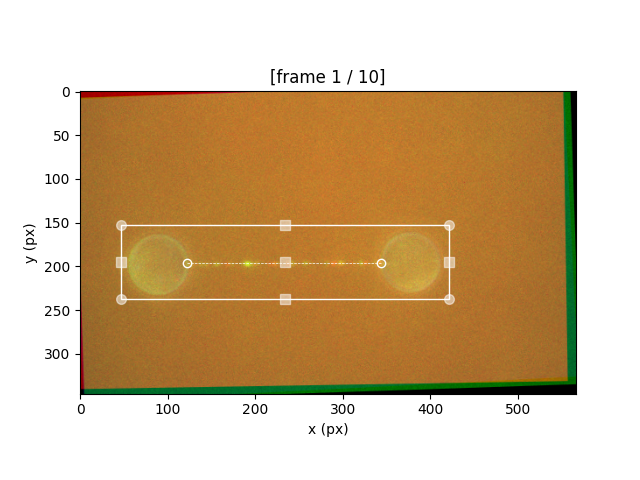

You can also use the mouse wheel to scroll through the individual frames (if using Jupyter Lab, hold `Shift` while scrolling).

Note that [`crop_and_rotate()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.ImageStack.html#lumicks.pylake.ImageStack.crop_and_rotate) accepts all of the arguments that can be used for [`plot()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.ImageStack.html#lumicks.pylake.ImageStack.plot).

To obtain a copy of the edited [`ImageStack`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.ImageStack.html#lumicks.pylake.ImageStack) object, use:

In [ ]:
plt.figure()
new_stack = editor.image
new_stack.plot()
new_stack.plot_tether()

## Kymotracking

<div class="alert alert-block alert-info"><b>Note: </b>For details of the tracking algorithms and downstream analyses see the <a href="https://lumicks-pylake.readthedocs.io/en/stable/tutorial/kymotracking.html">Kymotracking</a> tutorial.</div>

For tracking binding events on a kymograph, using the [`track_greedy()`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.track_greedy.html#lumicks.pylake.track_greedy) algorithm purely by function calls can be challenging if not all parts of the kymograph look the same or when the signal to noise ratio is somewhat low. To help with this, we included a kymotracking widget that can help you track subsections of the kymograph and iteratively tweak the algorithm parameters as you do so. You can open this widget by creating a [`KymoWidgetGreedy`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.KymoWidgetGreedy.html#lumicks.pylake.KymoWidgetGreedy) as follows:

In [ ]:
file = lk.File("test_data/kymo.h5")
kymo = file.kymos["16"]
kymowidget = lk.KymoWidgetGreedy(kymo, "green", axis_aspect_ratio=2)

Here we see the optional `axis_aspect_ratio` argument that allows us to control the aspect ratio of the plot and how much data is visible at a given time. You can easily pan horizontally by clicking and dragging left or right.

You can optionally also pass algorithm parameters when opening the widget:

In [ ]:
lk.KymoWidgetGreedy(kymo, "green", axis_aspect_ratio=2, min_length=4, pixel_threshold=9, window=6, sigma=0.2, correct_origin=True)

<div class="alert alert-block alert-danger"><b>Warning: </b>When saving tracks to a file, the widget samples a region around the tracked lines to obtained a summed intensity. Prior to version `1.1.0` the method <a href="https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.kymotracker.kymotrack.KymoTrack.html#lumicks.pylake.kymotracker.kymotrack.KymoTrack.sample_from_image">`sample_from_image()`</a> had a bug that assumed the origin of a pixel to be at the edge rather than the center of the pixel. Consequently, the sampled window could frequently be off by one pixel. To get the correct behavior and silence this warning, specify `correct_origin=True` when opening the kymotracking widget. The old (incorrect) behavior is maintained until the next major release to ensure backward compatibility. To silence this warning use `correct_origin=False`.</div>

You can also change the range of each of the algorithm parameter sliders. To do this, simply pass a dictionary where the key indicates the algorithm parameter and the value contains its desired range in the form `(minimum bound, maximum bound)`. For example:

In [ ]:
widget = lk.KymoWidgetGreedy(
    kymo,
    "green",
    axis_aspect_ratio=2,
    min_length=4,
    pixel_threshold=9,
    slider_ranges={"window": (0, 20)},
    window=20,
)

You can perform tracking by clicking the `Track all` button.

Detected tracks are accessible through the [`tracks`](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../_api/lumicks.pylake.KymoWidgetGreedy.html#lumicks.pylake.KymoWidgetGreedy.tracks) property:

In [ ]:
print(kymowidget.tracks)

For more information on its use, please see the example [Analyzing Cas9 binding to DNA](https://lumicks-pylake.readthedocs.io/en/stable/tutorial/../examples/cas9_kymotracking/cas9_kymotracking.html#id1).

## Migrating old track files

Prior to pylake `1.2.0`, tracks saved from the widget or API did not store the minimum length in the CSV file. This means that certain downstream analyses are not possible. To update a file with tracks to the new format, load the file in the widget, then filter the tracks by length using the largest minimum length you have used while tracking. You can do this as follows:

In [ ]:
filtered_tracks = lk.filter_tracks(widget.tracks, minimum_length=4)
filtered_tracks.save("fixed_file.csv")

where `4` should be replaced with a length relevant for your tracking settings.